#**Image Segmentation using U-Net on Oxford-IIIT Pet Dataset**

![alt text](https://www.tensorflow.org/static/tutorials/images/segmentation_files/output_a6u_Rblkteqb_3.png)

* This project implements image segmentation using the U-Net architecture on the
Oxford-IIIT Pet Dataset. Image segmentation is a computer vision task that involves labeling each pixel in an image with its corresponding class, allowing for detailed understanding of objects and their boundaries. In our case, we classify each pixel as either pet, background, or outline.

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR0MHfKHy88saCpraWzYuoL2Y2WKX_HkQgt5Q&s)

* The U-Net model, known for its U-shaped structure, consists of a contracting path to capture context and an expanding path to enable precise localization using skip connections. The Oxford-IIIT Pet Dataset contains over 7,000 images of 37 pet breeds with corresponding segmentation masks. The model processes these images to generate pixel-level predictions, enabling accurate pet segmentation with well-defined edges and minimal background noise.


## Importing libraries

In [2]:
import tensorflow as tf
import tensorflow.keras
import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Sequential , models
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Loading the dataset

In [3]:
dataset , info = tfds.load('oxford_iiit_pet', with_info=True)

## Preprocessing



To prepare the Oxford-IIIT Pet Dataset for training, several preprocessing steps were applied. First, each image and its corresponding segmentation mask were resized to a fixed dimension of 128x128 pixels. The pixel values of the images were normalized to the range [0, 1], and the mask values were adjusted by subtracting 1 to ensure class labels start from zero. For data augmentation, a random horizontal flip was applied to increase the diversity of training samples and improve generalization. The dataset was then batched, shuffled with a buffer size of 1000, and prefetching was enabled to ensure optimal performance during training. These preprocessing steps help stabilize and speed up the training process while improving model robustness.


In [4]:
len(dataset['train'])

3680

In [5]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32)/255
  input_mask = input_mask-1
  return input_image, input_mask

In [7]:
def load_train_images(sample):
  input_image= tf.image.resize(sample['image'],(128,128))
  input_mask = tf.image.resize(sample['segmentation_mask'],(128,128))
  if tf.random.uniform(())>0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image , input_mask


In [8]:
def load_test_images(sample):
  input_image= tf.image.resize(sample['image'],(128,128))
  input_mask = tf.image.resize(sample['segmentation_mask'],(128,128))
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image , input_mask

In [9]:
train_dataset = dataset['train'].map(load_train_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = dataset['test'].map(load_test_images,num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [10]:
BATCH_SIZE=64
BUFFER_SIZE=1000
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## EDA

In [11]:
def display_sample(image_list):
  plt.figure(figsize=(8,8))
  title = ['Input Image', 'True Mask' , 'Predicted Mask']
  for i in range(len(image_list)):
    plt.subplot(1,len(image_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
    plt.axis('off')
  plt.show()

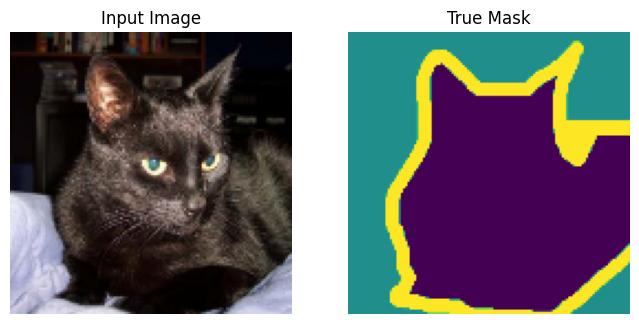

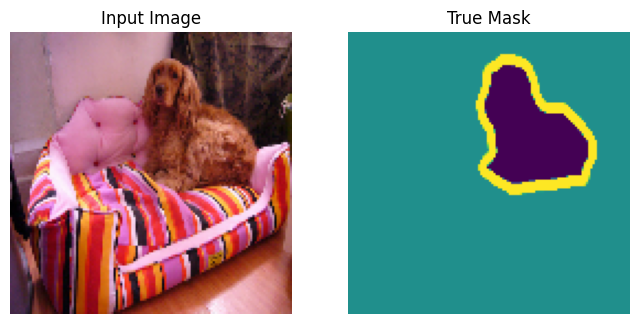

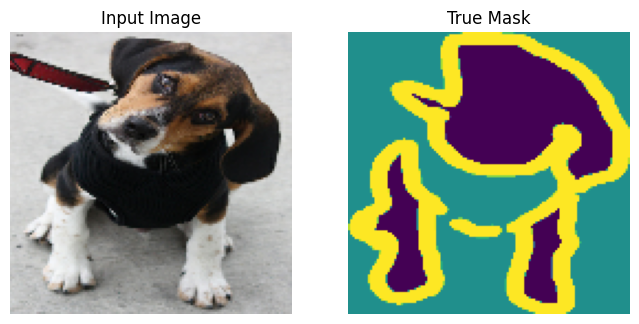

In [12]:
for images, masks in train_dataset.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display_sample([sample_image, sample_mask])

## Define U-Net Model

In [13]:
def double_conv_block(x, n_filters):
  x= Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
  x= Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
  return x

def downsample_block(x, n_filters):
  f = double_conv_block(x, n_filters)
  p = MaxPooling2D((2,2))(f)
  p = Dropout(0.3)(p)
  return f, p

def upsample_block(x,conv_features, n_filters):
  x= layers.Conv2DTranspose(n_filters,3,2, padding='same')(x)
  x= layers.Concatenate()([x, conv_features])
  x= Dropout(0.3)(x)
  x = double_conv_block(x, n_filters)
  return x

In [14]:
def build_unet_model(output_channels):
  inputs= layers.Input(shape=(128,128,3))
  f1, p1 = downsample_block(inputs, 64)
  f2, p2 = downsample_block(p1, 128)
  f3, p3 = downsample_block(p2, 256)
  f4, p4 = downsample_block(p3, 512)
  bottleneck = double_conv_block(p4, 1024)
  u6 = upsample_block(bottleneck, f4, 512)
  u7 = upsample_block(u6, f3, 256)
  u8 = upsample_block(u7, f2, 128)
  u9 = upsample_block(u8, f1, 64)
  outputs = layers.Conv2D(output_channels, 1, padding='same', activation='softmax')(u9)
  unet_model = tf.keras.Model(inputs, outputs, name='U-Net')
  return unet_model

In [15]:
output_channels=3
model= build_unet_model(output_channels)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ max_pooling2d_3[

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
EPOCHS=20
steps_per_epoch = info.splits['train'].num_examples // BATCH_SIZE
validation_steps = info.splits['test'].num_examples // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps, validation_data=test_dataset)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.5696 - loss: 1.0117 - val_accuracy: 0.5726 - val_loss: 0.8488
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5816 - loss: 0.8483 - val_accuracy: 0.5971 - val_loss: 0.8044
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6104 - loss: 0.7942 - val_accuracy: 0.6256 - val_loss: 0.7931
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6329 - loss: 0.7790 - val_accuracy: 0.6856 - val_loss: 0.8682
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6423 - loss: 0.7791 - val_accuracy: 0.6271 - val_loss: 0.7735
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6336 - loss: 0.7783 - val_accuracy: 0.6809 - val_loss: 0.7202
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7128 - loss: 0.6705 - val_accuracy: 0.7364 - val_loss: 0.6243
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7458 - loss: 0.6089 - val_accuracy: 0.7725 - val_los

## Visualize the results

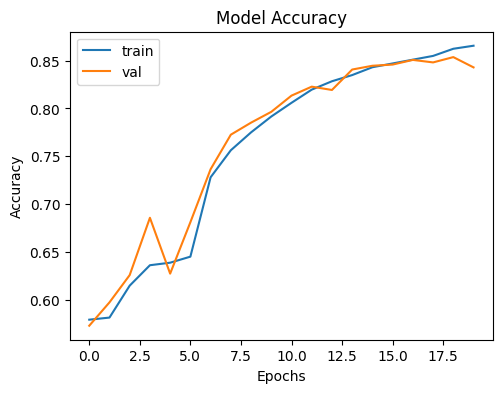

In [20]:
## plot train and val accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')




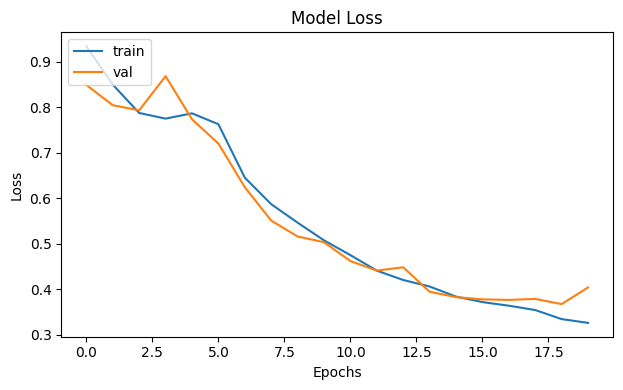

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

In [31]:
def create_mask(pred_msk):
  pred_mask = tf.argmax(pred_msk, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display = [image[0], mask[0], create_mask(pred_mask)]
      display_sample(display)

In [32]:
for image, mask in test_dataset.take(1):
  pred_mask = model.predict(image)

pred_mask = tf.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[..., tf.newaxis]
print(pred_mask[0].shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
(128, 128, 1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


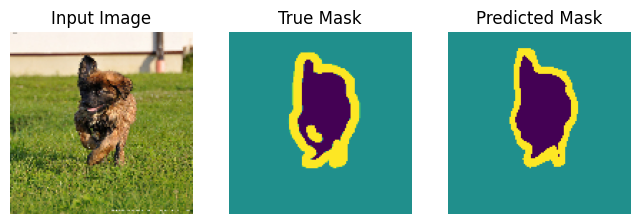

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


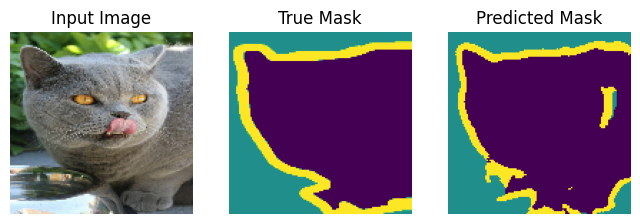

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


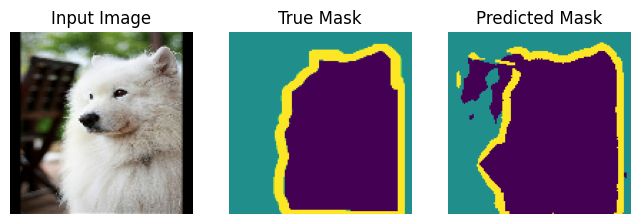

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


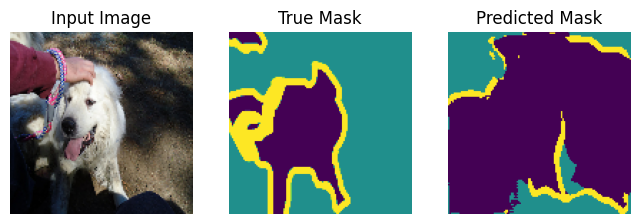

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


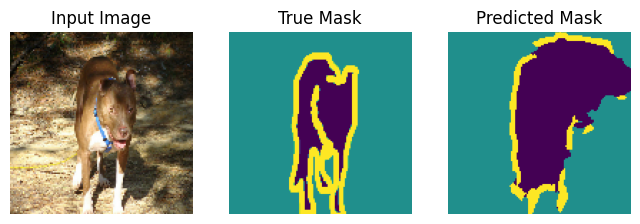

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


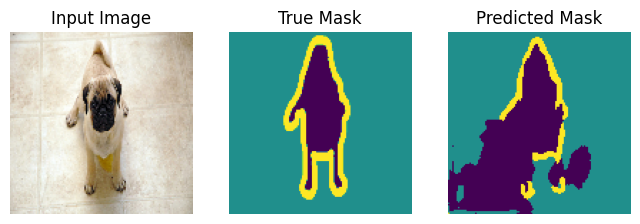

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


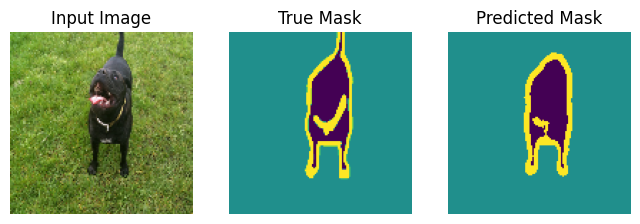

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


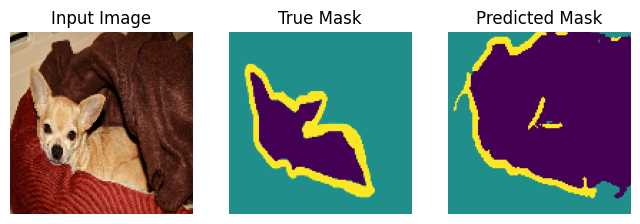

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


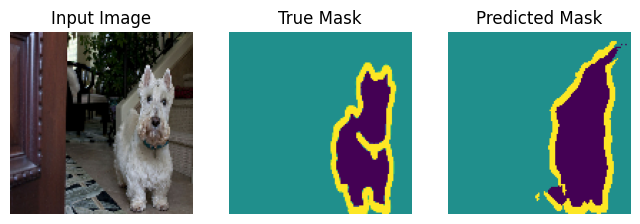

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


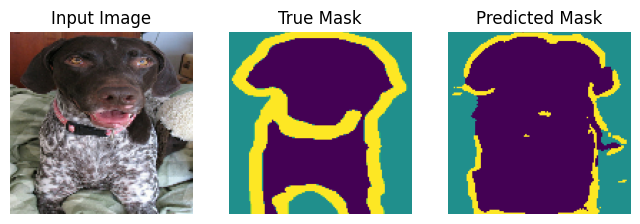

In [33]:
show_predictions(test_dataset,10)

In [38]:
model.save('history.h5')

## Model Evaluation

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 438ms/step - accuracy: 0.8434 - loss: 0.4016
Test Loss: 0.40391096472740173
Test Accuracy: 0.8430185914039612


In [37]:
from tensorflow.keras.metrics import MeanIoU

# Pick the number of classes (in Oxford-IIIT Pet, usually 3: pet, background, outline)
num_classes = 3
miou = MeanIoU(num_classes=num_classes)

for images, masks in test_dataset:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=-1)
    preds = preds[..., tf.newaxis]
    miou.update_state(masks, preds)

print("Mean IoU:", miou.result().numpy())

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

## **📊 Model Performance Summary**

The U-Net-based image segmentation model trained on the Oxford-IIIT Pet Dataset demonstrates strong performance in pixel-wise classification:

**Test Loss: 0.4039**

**Test Accuracy: 84.30%**

**Mean Intersection over Union (IoU): 0.65**

These metrics indicate that the model has effectively learned to distinguish between the foreground (pet), background, and outlines, achieving a reliable segmentation quality across the validation samples.

## **✅ Conclusion**

The U-Net architecture, known for its encoder-decoder structure and skip connections, proved to be highly effective for the task of semantic segmentation. With a test accuracy of over 84% and a mean IoU of 0.65, the model demonstrates a good balance between precision and recall in segmenting pet images. This validates the robustness of the chosen preprocessing pipeline and training strategy, making the model suitable for real-world image segmentation tasks where spatial accuracy is critical.